In [273]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping


from wordcloud import WordCloud
%matplotlib inline

import os

### Read animlist.csv

In [274]:
input_dir = os.path.join("..",'artifacts','raw')


rating_df = pd.read_csv(input_dir+'/animelist.csv', low_memory=True, usecols = ["user_id","anime_id","rating"])

In [275]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [276]:
len(rating_df)

5000000

### Data Processing

In [ ]:
n_rating = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_rating[n_rating >= 400].index)]   # Removing infrequent viewers
len(rating_df)

3246641

In [278]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])

print(min_rating)
print(max_rating)
print(avg_rating)

0
10
4.122732695114736


In [279]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating)/(max_rating-min_rating)).astype(np.float64)
rating_df['rating'].head()

213    0.0
214    1.0
215    0.0
216    0.0
217    0.0
Name: rating, dtype: float64

In [280]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])

print(min_rating)
print(max_rating)
print(avg_rating)

0.0
1.0
0.4122732695114736


In [281]:
rating_df.duplicated().sum()

np.int64(0)

In [282]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [283]:
unqiue_user_id = rating_df['user_id'].unique().tolist()

enc_user = {x: i for i, x in enumerate(unqiue_user_id)}  # Encoding to eliminate gaps
dec_user = {i: x for i, x in enumerate(unqiue_user_id)}

rating_df['user'] = rating_df['user_id'].map(enc_user)
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [284]:
n_user = len(enc_user)
n_user

4203

In [285]:
unqiue_anime_id = rating_df['anime_id'].unique().tolist()

enc_anime_id = {x: i for i, x in enumerate(unqiue_anime_id)}  # Encoding to eliminate gaps
dec_anime_id = {i: x for i, x in enumerate(unqiue_anime_id)}

rating_df['anime'] = rating_df['anime_id'].map(enc_anime_id)
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [286]:
n_anime = len(enc_anime_id )
n_anime

17149

In [287]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop = True)

In [288]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [289]:
x = rating_df[['user','anime']].values
y = rating_df['rating']

In [290]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [291]:
x_train, x_test, y_train, y_test = (
x[:train_indices],
x[train_indices :],
y[:train_indices],
y[train_indices :],
)

In [292]:
x_train_array = [x_train[:, 0], x_train[:,1]]
x_test_array = [x_test[:, 0], x_test[:,1]]

In [293]:
x_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81], shape=(3245641,)),
 array([1377, 1216, 1239, ...,  861, 2402, 1262], shape=(3245641,))]

# Model architechture

In [294]:
def RecommenderNet():
    embed_size = 128
    user = Input(name = 'user', shape = [1])
    user_embed = Embedding(name = "user_embedding", input_dim = n_user, output_dim= embed_size)(user)
    
    anime = Input(name= 'anime', shape = [1])
    anime_embed = Embedding(name = "anime_embedding", input_dim = n_anime, output_dim= embed_size)(anime)


    x = Dot(name = 'dot_prod', normalize= True, axes= 2)([user_embed,anime_embed])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs = [user, anime], outputs = x)
    model.compile(loss = "binary_crossentropy", metrics = ['mae','mse'], optimizer = 'Adam')
    return model




In [295]:
model = RecommenderNet()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_prod (Dot)      │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ dot_prod[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [296]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
susatian_epoch = 0
exp_deacy = 0.8

def lrfn(epoch):
    if epoch< rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs*epoch + start_lr
    elif epoch< rampup_epochs+susatian_epoch:
        return max_lr
    else:
        return (max_lr - min_lr) *exp_deacy **(epoch- rampup_epochs-susatian_epoch) +min_lr



In [297]:
lr_callbakc = LearningRateScheduler( lambda epoch: lrfn(epoch), verbose = 0)

checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only= True, monitor= "val_loss", mode = 'min', save_best_only= True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss", mode = 'min', restore_best_weights= True)

my_callbacks = [model_checkpoint, lr_callbakc, early_stopping]


In [298]:
history = model.fit(x = x_train_array, y =y_train, 
          batch_size= batch_size, 
          epochs= 20, verbose= 1, 
          validation_data= (x_test_array, y_test),
          callbacks = my_callbacks)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.8040 - mae: 0.3827 - mse: 0.1983 - val_loss: 0.7747 - val_mae: 0.3782 - val_mse: 0.1897 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.8004 - mae: 0.3814 - mse: 0.1969 - val_loss: 0.8097 - val_mae: 0.3850 - val_mse: 0.2012 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.7944 - mae: 0.3791 - mse: 0.1946 - val_loss: 0.8094 - val_mae: 0.3850 - val_mse: 0.2010 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.7858 - mae: 0.3758 - mse: 0.1912 - val_loss: 0.8060 - val_mae: 0.3844 - val_mse: 0.1999 - learning_rate: 3.4000e-05


In [299]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis = 1).reshape((-1,1))
    return weights

In [300]:
anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

### Reading anime.csv

In [301]:
df = pd.read_csv(input_dir + "/anime.csv")
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [302]:
df = df.replace('Unknown', np.nan)

In [303]:
def GetAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('Error')
    return name

In [304]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: GetAnimeName(x))
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [305]:
df.sort_values(by = 'Score',
               ascending= False,
               na_position= 'last',
               inplace= True)

df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [306]:
df = df[['anime_id', 'eng_version','Score', "Genres", "Episodes", "Type", 'Premiered', 'Members']]
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [307]:
def getanimeframe(anime, df):
    if isinstance(anime, int):
        return df[df['anime_id'] == anime]
    elif isinstance(anime, str):
        return df[df['eng_version'] == anime]
    

In [308]:
getanimeframe(5114,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [309]:
getanimeframe("Fullmetal Alchemist:Brotherhood",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [310]:
synposis_df = pd.read_csv(input_dir + '/anime_with_synopsis.csv')

In [311]:
synposis_df.drop('Score', axis=1, inplace=True)
synposis_df.head()


,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [312]:
def get_synopsys(anime,df):
    if isinstance(anime, int):
        return df[df['MAL_ID'] == anime]['sypnopsis'].values[0]
    elif isinstance(anime, str):
        return df[df['Name'] == anime]['sypnopsis'].values[0]
    
get_synopsys(40028,synposis_df)
    

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [313]:
synposis_df[synposis_df['Name'] == "Attack on Titan Final Season"	]

,MAL_ID,Name,Genres,sypnopsis


In [314]:
get_synopsys("Steins;Gate",synposis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### Content based recommendatation

In [315]:
pd.set_option("max_colwidth", None)


In [316]:
def FindSimilarAnime(name, anime_weights,enc_anime_id,dec_anime_id, df, 
                     synposis_df, n = 5, return_dist = False, neg = False):
    try:
        index = getanimeframe(name, df).anime_id.values[0]
        encoded_index = enc_anime_id.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])

        sorted_dist = np.argsort(dists)
        

        n = n+1

        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

       
        if return_dist:
            return dists, closest
        
        similartyarr = []
        
        for close in closest:
            decodec_id = dec_anime_id.get(close)
            
            
            
            animeframe = getanimeframe(decodec_id, df)
            
            anime_name = animeframe.eng_version.values[0]
            genre = animeframe.Genres.values[0]
            similarty = dists[close]
            
            similartyarr.append( {"anime_id": decodec_id,
                                'name':anime_name,
                                'genre': genre,
                                "similarty": similarty
                                  })
            
            
        recomend_df = pd.DataFrame(similartyarr).sort_values(by = 'similarty', ascending= False)
        return recomend_df[recomend_df['anime_id'] != index].drop(['anime_id'], axis = 1)
    except:
        print('error')

In [317]:
FindSimilarAnime("Naruto", anime_weights,enc_anime_id, dec_anime_id, df, synposis_df)

,name,genre,similarty
4,Norakuro Ittouhei,Kids,0.354854
3,Botsuraku,Music,0.318624
2,Nobara,Drama,0.318510
1,Strange+,"Slice of Life, Comedy, Josei",0.308644
0,JK to Inkou Kyoushi 4 feat. Ero Giin-sensei,"Hentai, School",0.306182


### User Based Recommendatation

In [318]:
def find_similar_user(item_input, user_weights, enc_user, dec_user, n = 5, return_dist = False, neg = False):
    try: 
        index = item_input
        enc_index = enc_user.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[enc_index])
        sorted_dist = np.argsort(dists)

        n = n+1

        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

       
        if return_dist:
            return dists, closest
        
        similartyarr = []
        
        for close in closest:

            similary = dists[close]

            if isinstance(item_input, int):
                dec_id = dec_user.get(close)
                similartyarr.append({'Similar User': dec_id,
                                     "Similarity": similary})
        similaruserdf = pd.DataFrame(similartyarr).sort_values(by = 'Similarity', ascending= False)
        similaruserdf = similaruserdf[similaruserdf['Similar User'] != item_input]
        return similaruserdf
    except Exception as e:
        print('error',e )
                
        

In [319]:
find_similar_user(11880,user_weights, enc_user, dec_user)

,Similar User,Similarity
4,519,0.276212
3,7509,0.275848
2,5408,0.265852
1,42,0.264674
0,8314,0.259721


In [320]:
def showwordcloud(all_genres):
    genre_cloud = WordCloud(width=700, height= 400, background_color= 'White', colormap= 'gnuplot' ).generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genre_cloud, interpolation= 'bilinear')
    plt.axis('off')
    plt.show()

In [321]:
from collections import defaultdict
def getFavGenre(frame, plot = False):
    frame.dropna(inplace = False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] +=1

    if plot:
        showwordcloud(all_genres)
    
    return genres_list

In [322]:
def get_user_pref(user_id, rating_df, df, plot = False):
    anime_watched_by_user = rating_df[rating_df['user_id'] == user_id]
    user_rating_percentile = np.percentile(anime_watched_by_user.rating, 75)

    anime_watched_by_user = anime_watched_by_user[anime_watched_by_user['rating'] >= user_rating_percentile]

    top_anime_by_user = (anime_watched_by_user.sort_values(by = 'rating', ascending = False).anime_id.values)

    anime_df_rows = df[df['anime_id'].isin(top_anime_by_user)]

    anime_df_rows = anime_df_rows[['eng_version', 'Genres']]

    if plot:
        getFavGenre(anime_df_rows, plot = True)

    return anime_df_rows

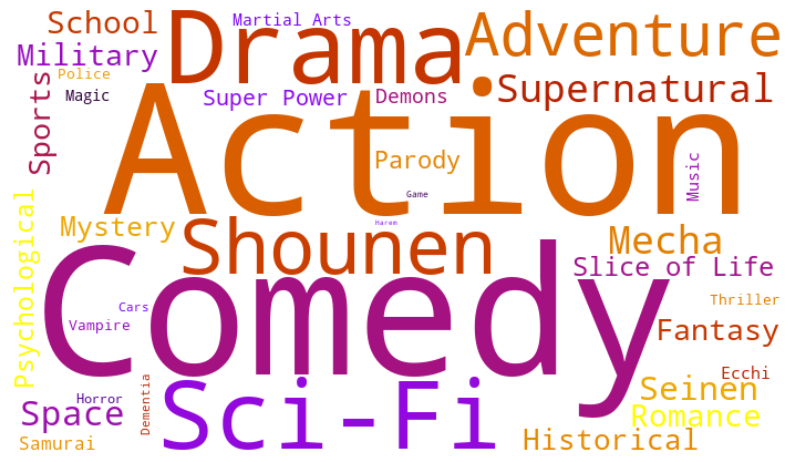

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [323]:
get_user_pref(11880, rating_df, df, plot= True)

In [324]:
def get_user_rec(similar_user, user_pref, df, rating_df, synposis_df, n = 5):
    recommended_anime = []
    anime_list = []

    for user_id in similar_user["Similar User"]:
        pref_list = get_user_pref(user_id, rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sortedlist = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sortedlist.index):
                n_user_pref = sortedlist[sortedlist.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getanimeframe(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = get_synopsys(int(anime_id), synposis_df)


                    recommended_anime.append({'n': n_user_pref,
                                              'anime_name': anime_name,
                                              'genre': genre,
                                              'synopsis': synopsis
                                              })
    
    return pd.DataFrame(recommended_anime).head(n)

In [325]:
similar_users = find_similar_user(int(11880),user_weights, enc_user, dec_user)
user_pref = get_user_pref(int(11880), rating_df, df, plot= False)
get_user_rec(similar_users,user_pref,df,rating_df, synposis_df)

,n,anime_name,genre,synopsis
0,5,Toradora!,"Slice of Life, Comedy, Romance, School","uuji Takasu is a gentle high school student with a love for housework; but in contrast to his kind nature, he has an intimidating face that often gets him labeled as a delinquent. On the other hand is Taiga Aisaka, a small, doll-like student, who is anything but a cute and fragile girl. Equipped with a wooden katana and feisty personality, Taiga is known throughout the school as the ""Palmtop Tiger."" One day, an embarrassing mistake causes the two students to cross paths. Ryuuji discovers that Taiga actually has a sweet side: she has a crush on the popular vice president, Yuusaku Kitamura, who happens to be his best friend. But things only get crazier when Ryuuji reveals that he has a crush on Minori Kushieda—Taiga's best friend! Toradora! is a romantic comedy that follows this odd duo as they embark on a quest to help each other with their respective crushes, forming an unlikely alliance in the process."
1,5,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
2,5,Noragami:Stray God,"Action, Adventure, Comedy, Supernatural, Shounen","In times of need, if you look in the right place, you just may see a strange telephone number scrawled in red. If you call this number, you will hear a young man introduce himself as the Yato God. Yato is a minor deity and a self-proclaimed ""Delivery God,"" who dreams of having millions of worshippers. Without a single shrine dedicated to his name, however, his goals are far from being realized. He spends his days doing odd jobs for five yen apiece, until his weapon partner becomes fed up with her useless master and deserts him. Just as things seem to be looking grim for the god, his fortune changes when a middle school girl, Hiyori Iki, supposedly saves Yato from a car accident, taking the hit for him. Remarkably, she survives, but the event has caused her soul to become loose and hence able to leave her body. Hiyori demands that Yato return her to normal, but upon learning that he needs a new partner to do so, reluctantly agrees to help him find one. And with Hiyori's help, Yato's luck may finally be turning around."
3,5,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unrave

In [326]:
def hybrid_recom(user_id, user_weight = 0.5, content_weight = 0.5):
    #User Recommendation
    
    similar_users = find_similar_user(int(user_id),user_weights, enc_user, dec_user)
    user_pref = get_user_pref(int(user_id), rating_df, df, plot= False)
    user_rec_anime = get_user_rec(similar_users,user_pref,df,rating_df, synposis_df)

    user_rec_anime_list = user_rec_anime['anime_name'].to_list()

    #Contnet Recommendation
    content_rec_anime = []

    for anime in user_rec_anime_list:
        similar_content = FindSimilarAnime(anime, anime_weights,enc_anime_id, dec_anime_id, df, synposis_df)

        if similar_content is not None and not similar_content.empty:
            content_rec_anime.extend(similar_content['name'].to_list())
        else:
            print(f'no similar anime found {anime}')

    combine_score = {}

    for anime in user_rec_anime_list:
        combine_score[anime] = combine_score.get(anime,0) + user_weight
    for anime in content_rec_anime:
        combine_score[anime] = combine_score.get(anime,0) + content_weight

    sorted_anime = sorted(combine_score.items(), key = lambda x:x[1], reverse = True)

    return [anime for anime, score in sorted_anime[:10]]

In [327]:
hybrid_recom(13994)

['Sore Ike! Anpanman: Otanjoubi Series',
 'Demon Slayer:Kimetsu no Yaiba',
 'Haikyu!! 2nd Season',
 'Haikyu!! 3rd Season',
 'Your Lie in April',
 'Your Name.',
 'Dokushin Apartment Dokudami-sou',
 'Hamatora The Animation',
 'Xing Wushen Jue',
 'Watashitachi, Luck Logic-bu! 2']